<a href="https://colab.research.google.com/github/Kritarth-Dandapat/AI-Projects/blob/main/Human_emotions_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import time
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from google.colab import drive

In [ ]:
train_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/train"
test_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/test"

CLASS_NAMES = ["angry", "happy", "sad"]
BATCH_SIZE = 32
IMG_SIZE = 256

CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}

# Data Installation

In [ ]:
!pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/


cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
! chmod 600 /root/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
! kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

Dataset URL: https://www.kaggle.com/datasets/muhammadhananasghar/human-emotions-datasethes
License(s): unknown
 99% 305M/309M [00:05<00:00, 32.4MB/s]
100% 309M/309M [00:05<00:00, 59.5MB/s]


In [ ]:
! unzip '/content/human-emotions-datasethes.zip' -d "/content/dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/EmotionsDataset/data/nothing/720.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/721.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/722.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/723.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/724.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/725.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/726.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/727.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/728.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/729.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/73.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/730.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/731.jpg  
  inflating: /content/dataset/EmotionsDataset/data/no

# Data Preprocessing

In [ ]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
    validation_split=0.2,
    subset="training",
)

Found 6799 files belonging to 3 classes.
Using 5440 files for training.


In [ ]:
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
    validation_split=0.2,
    subset="validation",
)

Found 6799 files belonging to 3 classes.
Using 1359 files for validation.


In [ ]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
)

Found 2278 files belonging to 3 classes.


In [ ]:
test_dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

# Data Visulaization

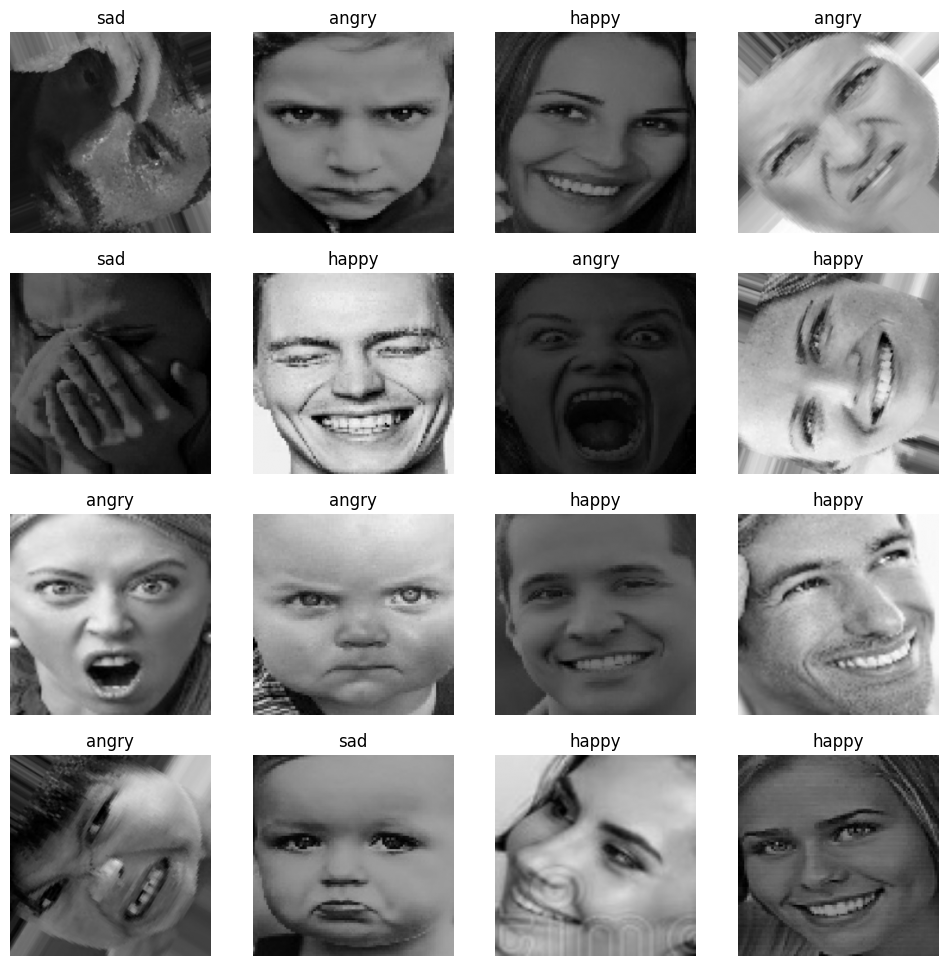

In [ ]:
plt.figure(figsize=(12, 12))
for images, labels in train_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8")/255)
        plt.title(CLASS_NAMES[np.argmax(labels[i])])
        plt.axis("off")

# Data Augmentation


In [ ]:
###tf.keras.layer.augmet

augment_layers = tf.keras.Sequential([
    RandomFlip(mode = "horizontal"),
    RandomRotation(factor=(-0.025, 0.025)),
    RandomContrast(0.2),
])

In [ ]:
def augment_layer(image, label):
    return augment_layers(image, training = True), label

## CutMix Augmentation

In [ ]:
def box(lamda):

  r_x = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, CONFIGURATION["IM_SIZE"])
  r_y = tf.clip_by_value(r_y - r_h//2, 0, CONFIGURATION["IM_SIZE"])

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, CONFIGURATION["IM_SIZE"])
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, CONFIGURATION["IM_SIZE"])

  r_w = x_b_r - r_x
  if(r_w == 0):
    r_w  = 1

  r_h = y_b_r - r_y
  if(r_h == 0):
    r_h = 1

  return r_y, r_x, r_h, r_w

In [ ]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(2,2)
  lamda = lamda.sample(1)[0]

  r_y, r_x, r_h, r_w = box(lamda)
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1- (r_w*r_h)/(CONFIGURATION["IM_SIZE"]*CONFIGURATION["IM_SIZE"]), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image, label

# Data Preperation

In [ ]:
train_dataset_1 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
train_dataset_2 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [ ]:
train_dataset = (
    mixed_dataset
    .map(cutmix, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
# train_dataset = train_dataset.map(augment_layer).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

In [ ]:
def create_example(image, label):
  int_feature = tf.train.Feature(
      int64_list=tf.train.Int64List(value=[label]))
  bytes_feature = tf.train.Feature(
      bytes_list=tf.train.BytesList(value=[image]))

  example = tf.train.Example(
      features=tf.train.Features(feature={
          'label': int_feature,
          'images': bytes_feature,
      }))

  return example.SerializeToString()

In [ ]:
def encode_image(image, label):
  image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
  image = tf.image.encode_jpeg(image)
  return image, label

In [ ]:
# encoded_dataset = train_dataset.map(encode_image)

In [ ]:
NUM_SHARDS = 10
PATH = '/content/tfrecords/shard_{:02d}.tfrecord'

In [ ]:
# Write the records to a file.

# for shard_number in range(NUM_SHARDS):

#   shard_dataset = train_dataset.shard(NUM_SHARDS, shard_number)
#   with tf.io.TFRecordWriter(PATH.format(shard_number)) as file_writer:
#     for image,label in shard_dataset:
#       image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
#       file_writer.write(create_example(image,label))

NotFoundError: /content/tfrecords/shard_00.tfrecord; No such file or directory

In [ ]:
resize_rescale_layers = tf.keras.Sequential([
    tf.keras.layers.Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    tf.keras.layers.Rescaling(1./255)
])

# Modeling

### Lenet Model

In [ ]:
lenet_model = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None, None, 3), ),

    resize_rescale_layers,

    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),

    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),

    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

lenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 6)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 127, 127, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)     

### ResNet

In [ ]:
class CustomConv2D(Layer):
  def __init__(self, n_filters, kernel_size, n_strides, padding = 'valid'):
    super(CustomConv2D, self).__init__(name = 'custom_conv2d')

    self.conv = Conv2D(
        filters = n_filters,
        kernel_size = kernel_size,
        activation = 'relu',
        strides = n_strides,
        padding = padding)

    self.batch_norm = BatchNormalization()

  def call(self, x, training = True):

    x = self.conv(x)
    x = self.batch_norm(x, training)

    return x

In [ ]:
class ResidualBlock(Layer):
  def __init__(self, n_channels, n_strides = 1):
    super(ResidualBlock, self).__init__(name = 'res_block')

    self.dotted = (n_strides != 1)

    self.custom_conv_1 = CustomConv2D(n_channels, 3, n_strides, padding = "same")
    self.custom_conv_2 = CustomConv2D(n_channels, 3, 1, padding = "same")

    self.activation = Activation('relu')

    if self.dotted:
      self.custom_conv_3 = CustomConv2D(n_channels, 1, n_strides)

  def call(self, input, training):

    x = self.custom_conv_1(input, training)
    x = self.custom_conv_2(x, training)

    if self.dotted:
      x_add = self.custom_conv_3(input, training)
      x_add = Add()([x, x_add])
    else:
      x_add = Add()([x, input])

    return self.activation(x_add)


In [ ]:
class ResNet34(Model):
  def __init__(self,):
    super(ResNet34, self).__init__(name = 'resnet_34')

    self.conv_1 = CustomConv2D(64, 7, 2, padding = 'same')
    self.max_pool = MaxPooling2D(3,2)

    self.conv_2_1 = ResidualBlock(64)
    self.conv_2_2 = ResidualBlock(64)
    self.conv_2_3 = ResidualBlock(64)

    self.conv_3_1 = ResidualBlock(128, 2)
    self.conv_3_2 = ResidualBlock(128)
    self.conv_3_3 = ResidualBlock(128)
    self.conv_3_4 = ResidualBlock(128)

    self.conv_4_1 = ResidualBlock(256, 2)
    self.conv_4_2 = ResidualBlock(256)
    self.conv_4_3 = ResidualBlock(256)
    self.conv_4_4 = ResidualBlock(256)
    self.conv_4_5 = ResidualBlock(256)
    self.conv_4_6 = ResidualBlock(256)

    self.conv_5_1 = ResidualBlock(512, 2)
    self.conv_5_2 = ResidualBlock(512)
    self.conv_5_3 = ResidualBlock(512)

    self.global_pool = GlobalAveragePooling2D()

    self.fc_3 = Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax')

  def call(self, x, training = True):
    x = self.conv_1(x)
    x = self.max_pool(x)

    x = self.conv_2_1(x, training)
    x = self.conv_2_2(x, training)
    x = self.conv_2_3(x, training)

    x = self.conv_3_1(x, training)
    x = self.conv_3_2(x, training)
    x = self.conv_3_3(x, training)
    x = self.conv_3_4(x, training)

    x = self.conv_4_1(x, training)
    x = self.conv_4_2(x, training)
    x = self.conv_4_3(x, training)
    x = self.conv_4_4(x, training)
    x = self.conv_4_5(x, training)
    x = self.conv_4_6(x, training)

    x = self.conv_5_1(x, training)
    x = self.conv_5_2(x, training)
    x = self.conv_5_3(x, training)

    x = self.global_pool(x)

    return self.fc_3(x)

## VIT


In [ ]:
test_image  = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/109540.jpg_rotation_2.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]))

In [ ]:
patches = tf.image.extract_patches(
    images = tf.expand_dims(test_image, axis = 0),
    sizes = [1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
    strides = [1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
    rates = [1, 1, 1, 1],
    padding = 'VALID',
)

In [ ]:
print(patches.shape)
patches = tf.reshape(patches, (1, -1, CONFIGURATION["PATCH_SIZE"]*CONFIGURATION["PATCH_SIZE"]*3))
print(patches.shape)

(1, 16, 16, 768)
(1, 256, 768)


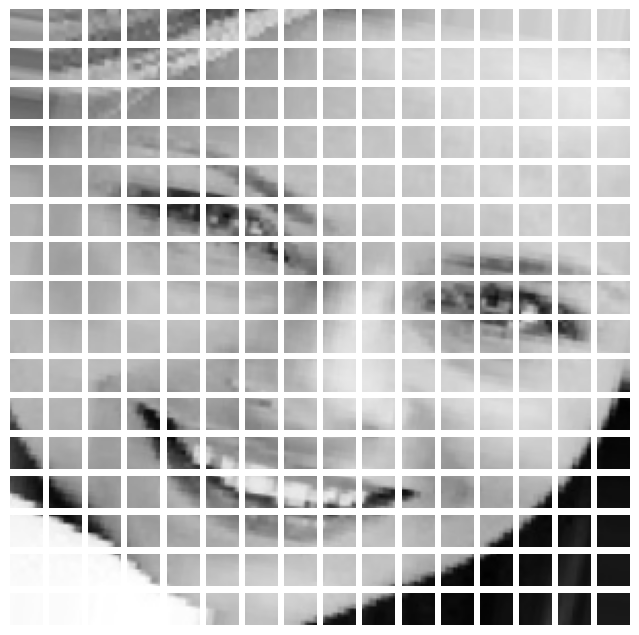

In [ ]:
plt.figure(figsize=(8, 8))

for i in range(patches.shape[1]):
    ax = plt.subplot(16,16, i + 1)
    plt.imshow(tf.reshape(patches[0, i,:], (CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 3)))
    plt.axis("off")

In [ ]:
class PatchEncoder(Layer):
  def __init__(self, N_PATCHES, HIDDEN_SIZE):
    super(PatchEncoder, self).__init__(name = 'patch_encoder')

    self.linear_projection = Dense(HIDDEN_SIZE)
    self.positional_embedding = Embedding(N_PATCHES, HIDDEN_SIZE )
    self.N_PATCHES = N_PATCHES

  def call(self, x):
    patches = tf.image.extract_patches(
        images=x,
        sizes=[1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
        strides=[1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
        rates=[1, 1, 1, 1],
        padding='VALID')

    patches = tf.reshape(patches, (tf.shape(patches)[0], 256, patches.shape[-1]))

    embedding_input = tf.range(start = 0, limit = self.N_PATCHES, delta = 1 )
    output = self.linear_projection(patches) + self.positional_embedding(embedding_input)

    return output

## Transfer Learning

In [ ]:
backbone = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top = False,
    weights = 'imagenet',
    input_shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3)
)

In [ ]:
backbone.trainable = False

In [ ]:
transfered_model = tf.keras.Sequential([
    Input(shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3)),
    backbone,
    GlobalAveragePooling2D(),
    Dense(CONFIGURATION["N_DENSE_1"], activation = "relu"),
    BatchNormalization(),
    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

transfered_model.summary()

## FineTuning Model

In [ ]:
input = Input(shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3))
x = backbone(input)
x = GlobalAveragePooling2D(x)
x = Dense(CONFIGURATION["N_DENSE_1"], activation = "relu")(x)
x = BatchNormalization(x)
output = Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax")(x)



finetuned_model = Model(output, input)
finetuned_model.summary()

# Training

In [ ]:
loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits = False)

In [ ]:
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(2, name = "top_k_accuracy")]

In [ ]:
model = transfered_model


In [ ]:
model.compile(
    optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]/100),
    loss = loss_function,
    metrics = metrics
)

In [ ]:
history = model.fit(
    train_dataset,
    # epochs = CONFIGURATION["N_EPOCHS"],
    epochs = 5,
    validation_data = val_dataset,
    verbose = 1
)

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

## Evaluation

In [ ]:
model.evaluate(test_dataset)

# Testing

In [ ]:
test_image  = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/109540.jpg_rotation_2.jpg")

im = tf.constant(test_image)
im = tf.image.resize(im, (256, 256))
im = tf.cast(im, tf.float32)

print(model.predict(im.numpy().reshape(1, 256, 256, 3)))

In [ ]:
plt.figure(figsize=(12, 12))
for images, labels in val_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8")/255)
        plt.title("\n True Label - :" + CLASS_NAMES[np.argmax(labels[i])] + "\n Predicted Label -: " + CLASS_NAMES[np.argmax(model.predict(images[i].numpy().reshape(1, 256, 256, 3)))])
        plt.axis("off")

## Confusion Matric

In [ ]:
predicted = []
labels = []

for im, label in val_dataset:
    predicted.extend(np.argmax(model.predict(im), axis=1))
    labels.extend(np.argmax(label, axis=1))



In [ ]:
predicted = np.array(predicted)
labels = np.array(labels)

cm  = confusion_matrix(labels, predicted)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Visualization

In [ ]:
vggbackbone = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=None,
)

In [ ]:
vggbackbone.summary()

In [ ]:
def is_conv(layer_name):
  if "conv" in layer_name:
    return True
  else:
    return False

In [ ]:
feature_maps = [layer.output for layer in vggbackbone.layers[1:] if is_conv(layer.name) == True]
feature_maps_model = Model(
    inputs = vggbackbone.input,
    outputs = feature_maps
)

feature_maps_model.summary()

In [ ]:
test_image  = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/109540.jpg_rotation_2.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]))

im = tf.constant(test_image)
im = tf.cast(im, tf.float32)
im = tf.expand_dims(im, axis = 0)

f_maps = feature_maps_model.predict(im)

In [ ]:
len(f_maps)

In [ ]:
for i in range(len(f_maps)):
  print(f_maps[i].shape)

In [ ]:
for i in range(len(f_maps)):
  plt.figure(figsize=(256, 256))
  f_size = f_maps[i].shape[1]
  n_chanels = f_maps[i].shape[3]
  jointmaps =np.ones((f_size, f_size*n_chanels))

  ax = plt.subplot(len(f_maps),1,  i + 1)

  for j in range(n_chanels):
    jointmaps[:, j*f_size:(j+1)*f_size] = f_maps[i][..., j]

  plt.imshow(jointmaps[:, 0:512])
  plt.axis("off")
  plt.show()
